In [91]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from helper_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 7.0)

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [94]:
def preprocess(dataframe_csvpath, cols_x, cols_y, window_in, window_out, data_div_frac, popu_size):

    """
    Converts the Csv file into required data format for Time Series prediction    
    
    Arguments:
    dataframe_csvpath -- path of csv file, it has the data for different time sceries
    cols_x -- list of columns to be considered as input to the model(Include 'Series_No' as last entry in list)
    cols_y -- list of columns to be outputed by the model(Include 'Series_No' as last entry in list)
    window_in -- the number of time steps as input
    window_out -- the number of time steps to be predicted
    data_div_frac -- the % of data to be divide into test and train sets  
    popu_size -- population size to normalize data
        
        
    Returns:  
    x_train -- the training input data of shape (m, window_in, len(cols_x)); m is number of examples 
    y_train -- the training data labels for input data of shape (m, window_out, len(cols_y)); m is number of examples 
    x_test -- the testing input data of shape (m, window_in, len(cols_x)); m is number of examples  
    y_test -- the testing data labels of shape (m, window_out, cols_y); m is number of examples  
    len_ser -- the total number of days in a series
    win_len_per_ser -- the total number of windows in a series
    
    """
  
    #Loading .CSV file and creating dataframe
    df = pd.read_csv(dataframe_csvpath)   
    len_ser = len(df[df['Series_No'] == 1])

    #randomly shuffle different series
    permute = np.random.permutation(range(1, len(set(df['Series_No']))))
    train_series_seq = permute[: int(len(set(df['Series_No'])) * data_div_frac)]
    test_series_seq = permute[int( len(set(df['Series_No'])) * data_div_frac):]
    
    #taking relevent columns from dataframe  
    df_x = df[cols_x]
    df_y = df[cols_y]
    
    #Innitialize empty lists which are later to be appended
    train_seq, test_seq = [], []
    
    #Creating time series data
    for series_no in train_series_seq:
        
        #new dataframe variable assignment for particular series drom df_x, df_y
        series_df_x = df_x[df_x['Series_No'] == series_no]
        series_df_y = df_x[df_y['Series_No'] == series_no]
        
        #converting into numpy arrays
        array_x = np.array(series_df_x)
        array_y = np.array(series_df_y)
        
        #for loop to append to x_train y_train arrays according to window_in, window_out
        for idx in range(len(series_df_x) - window_in - window_out + 1): #'len(series_df_x) - window_in - window_out + 1' needs to be checked
            x = array_x[idx:idx + window_in, : len(cols_x) - 1]
            x[:,0:3] = x[:,0:3] / popu_size
            y = array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1]
            y = y / popu_size
            train_seq.append((x, y)) #out col_x and col_y has last item 'Series number' so to remove that [, : len(cols_x)]
            #y_train.append(array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1])
            #print(train_seq)

    #repeat for test sequence
    for series_no in test_series_seq:
        
        #new dataframe variable assignment for particular series drom df_x, df_y
        series_df_x = df_x[df_x['Series_No'] == series_no]
        series_df_y = df_x[df_y['Series_No'] == series_no]
        
        #converting into numpy arrays
        array_x = np.array(series_df_x)
        array_y = np.array(series_df_y)
        
        #for loop to append to x_train y_train arrays according to window_in, window_out
        for idx in range(len(series_df_x) - window_in - window_out + 1): #'len(series_df_x) - window_in - window_out + 1' needs to be checked
            x = array_x[idx:idx + window_in, : len(cols_x) - 1]
            x[:,0:3] = x[:,0:3] / popu_size
            y = array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1]
            y = y / popu_size
            test_seq.append((x, y))
            
            
            #test_seq.append((array_x[idx:idx + window_in, : len(cols_x) - 1], array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1])) #out col_x and col_y has last item 'Series number' so to remove that [, : len(cols_x)]
            #y_test.append(array_y[idx + window_in :idx + window_in + window_out, : len(cols_y) - 1])

    
    win_len_per_ser = len_ser - window_in - window_out + 1
    
    return np.array(train_seq), np.array(test_seq), len_ser, win_len_per_ser

In [95]:
window_in = 7
window_out = 1
colsx = ['Cumulative True Cases','Free','Positively Tested','CR', 'Series_No']
colsy = ['Cumulative True Cases','Free','Positively Tested', 'Series_No']
input_shape = (window_in, len(colsx) - 1)
train_seq, test_seq, len_of_ser, num_windows_ser = preprocess(dataframe_csvpath = "data.csv", 
    cols_x = colsx, 
    cols_y = colsy, 
    window_in = window_in, 
    window_out = window_out, 
    data_div_frac = 0.99, 
    popu_size = 80000
)

C:\Users\matha\AppData\Local\Temp/ipykernel_2820/3458737622.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train_seq), np.array(test_seq), len_ser, win_len_per_ser


In [96]:
class TSD(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        window, target = self.sequences[idx]
        return torch.tensor(window), torch.tensor(target)

    

In [97]:
train_seq_obj = TSD(train_seq)
test_seq_obj = TSD(test_seq)

In [98]:
class LSTM_TS(nn.Module):
    def __init__(self, nfeat_x, nfeat_y, window_in, window_out):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=nfeat_x, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128*2, hidden_size=256, batch_first=True, num_layers=2 , dropout=0.3, bidirectional =True)
        self.lstm3 = nn.LSTM(input_size= 256 * 2, hidden_size=128, batch_first=True,  bidirectional=True)
        self.fc = nn.Linear(2*128*window_in, nfeat_y)
        self.yfeat = nfeat_y
        self.xfeat = nfeat_x
        self.win_in = window_in
        self.win_out = window_out
        self.silu = nn.SiLU()
        self.selu = F.selu


    def forward(self, x):
        x, _ = self.lstm1(x)
        #print('lstm1', x.shape)
        x, _ = self.lstm2(x)
        #print('lstm2',x.shape)
        x, _ = self.lstm3(x)
        #print('lstm3',x.shape)
        x = self.selu(x)
        x = x.reshape((x.shape[0], -1))
        #print('reshape1',x.shape)
        x = self.fc(x)
        x = self.silu(x)
        y = x.reshape((x.shape[0], self.win_out, self.yfeat))
        #print('reshapefc1', y.shape)
        
        return y


In [54]:
class LSTM_RNN_TS(nn.Module):
    def __init__(self, nfeat_x, nfeat_y, window_in, window_out):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=nfeat_x, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128*2, hidden_size=256, batch_first=True, dropout=0.3, bidirectional =True)
        self.lstm3 = nn.LSTM(input_size= 256 * 2, hidden_size=128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*128*window_in, nfeat_y)
        self.yfeat = nfeat_y
        self.xfeat = nfeat_x
        self.win_in = window_in
        self.win_out = window_out
        self.silu = nn.SiLU()
        self.rnn = nn.RNN(input_size=1792, hidden_size=nfeat_y, nonlinearity='tanh', batch_first=True)


    def forward(self, x):
        x, _ = self.lstm1(x)
        #print('lstm1', x.shape)
        x, _ = self.lstm2(x)
        #print('lstm2',x.shape)
        x, _ = self.lstm3(x)
        #print('lstm3',x.shape)
        x = self.silu(x)
        x = x.reshape((x.shape[0], self.win_out, -1))
        #print('reshape1',x.shape)
        x, _ = self.rnn(x)
        #print(x.shape) # x = self.fc(x)
        # x = self.silu(x)
        # y = x.reshape((x.shape[0], self.win_out, self.yfeat))
        #print('reshapefc1', y.shape)
        
        return x

In [99]:
model = LSTM_TS(nfeat_x=4, nfeat_y=3, window_in=window_in, window_out=window_out).to(device)
print(model)

LSTM_TS(
  (lstm1): LSTM(4, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm3): LSTM(512, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1792, out_features=3, bias=True)
  (silu): SiLU()
)


In [100]:
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [108]:
train_loader = DataLoader(dataset=train_seq_obj, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_seq_obj, batch_size=64, shuffle=False) #always same batch_size

In [102]:
num_epochs = 10
for epoch in range(num_epochs):
    for idx, (ser, targets) in enumerate(train_loader):
         
        ser = ser.float().to(device)
        targets = targets.float().to(device)
        #print(ser.shape)
        #print(targets.shape)
        pred = model(ser)
        #print(pred[5])
        loss = criterion(pred, targets)
        

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        

    
    print(f'loss after epoch {epoch + 1} is {loss: 5f}')



loss after epoch 1 is  0.044013
loss after epoch 2 is  0.041136
loss after epoch 3 is  0.041123
loss after epoch 4 is  0.041155
loss after epoch 5 is  0.041115
loss after epoch 6 is  0.041117
loss after epoch 7 is  0.041124
loss after epoch 8 is  0.041118
loss after epoch 9 is  0.041118
loss after epoch 10 is  0.041123


In [106]:
def predictions(loader, model, win_len_per_ser, criterion, window_out = 1):
    """
    Makes Predictions for time series data using the model trained.   
    
    Arguments:
    x_test, y_test -- Testing data
    model -- Model trained previously
    len_seq -- The length of days in a paricular time-series
    window_in -- The input window size for the model
    window_out -- The predicted window size of model
    
    
    Returns:  
    y_pred -- The predicted windows (for plotting)
    mae -- Mean absolute Error of y_pred and y_true
    
    """
  
    model.eval()
    num_win_per_ser = win_len_per_ser   #num windows
    #print(num_win_per_ser)
    y_pred = []
    y_true = []
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):  #for i in range(0, len(y_test), num_win_per_ser): # i takes index values of first windows of different series
            
            win_start = torch.tensor(x[0]).float().to(device) # saving the first window of each series
            #print('win_start:', win_start)
            CR = win_start[0][3] # saving the CR value for particular series -> to be used for prediction
            #print('CR:', CR)
            win = win_start # window variable which will be updated for new windows, takes first value as the starting window
            #print(win)
            win = win.reshape((1, win.shape[0], win.shape[1]))
            #print(win.shape)
            for j in range(num_win_per_ser): # prediction loop 
                y_hat = model(win) # predicting values wrt win variable
                #print('y_hat ', y_hat)  
                y_pred.append(y_hat[0].cpu().detach().numpy()) # add the value to y_pred
                #print('y_pred:', y_pred)
                y_true.append(targets[j].cpu().detach().numpy()) # add the value to y_pred
                #print('y_true:', y_true)
                cr_dummy = torch.empty((1, window_out, 1), dtype=torch.float32).to(device)
                y_hat = torch.cat((y_hat, cr_dummy.fill_(float(CR))), 2).float()
                #y_hat = tf.concat([y_hat, tf.fill(dims = (1, window_out, 1), value = CR)], axis = 2) # adding CR value y_hat for furter predictions
                #print('cr added to y_hat', y_hat)   
                win = torch.cat((win, y_hat), 1)
                #win = tf.concat([win, y_hat], axis = 1) # adding our prediction to win
                #print('win', win)
                win = win[:,window_out:,:] # updating win by removing the starting elements
                #print('new_win for next iter', win)

    
        y_pred = torch.tensor(y_pred).to(device)
        y_true = torch.tensor(y_true).to(device)
        assert (y_pred.shape == y_true.shape)

        mae = criterion(y_pred, y_true)
        #mae = tf.reduce_sum(tf.keras.metrics.mean_absolute_error(y_pred, y_test))
        print(f'The error is: " {mae: .5f}')

    model.train()
    return y_pred.cpu().detach().numpy(), y_true.cpu().detach().numpy(), mae.cpu().detach().numpy()



In [109]:
y_pred, y_true, mae = predictions(loader=test_loader, model = model, win_len_per_ser=num_windows_ser, criterion=criterion,window_out=window_out)

C:\Users\matha\AppData\Local\Temp/ipykernel_2820/727582639.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  win_start = torch.tensor(x[0]).float().to(device) # saving the first window of each series


IndexError: index 20 is out of bounds for dimension 0 with size 20

In [89]:
def visualize(y_test, y_pred, test_seq, window_out, num_plots, num_win_ser, cols_y, col_idx):
    """
    Visualize a particular column of Y_pred anf Y_test for a particular series
    
    Arguments:
    y_test -- The test y array
    y_pred -- The prediction array
    x_test -- The test x array
    window_out -- len of output window
    num_plots -- Number of plots to show(number of differnt series)
    num_win_ser -- Number of windows in a particular series
    cols_y -- List of stings with column names in y
    col_idx -- Column index to plot


    """
    
    
    ser_idx = [i for i in range(0, len(y_test), num_win_ser)]
    if num_plots > len(ser_idx):
        print("Too many plots, reduce the mumber")
    else:
        indx = ser_idx[0:num_plots]
        days = range(num_win_ser)
        for idx in indx:
            CR = test_seq[idx][0][0][3]
            pred = y_pred[idx : idx+num_win_ser, window_out -1, col_idx]
            true = y_test[idx : idx+num_win_ser, window_out -1,  col_idx]
            
            plt.title("Y_True V/S Y_Pred, CR: "+ str(CR))
            plt.xlabel('Days')
            plt.ylabel(cols_y[col_idx])
            
            plt.plot(days, pred, label = 'Pred')
            plt.plot(days, true, label = 'True')
            
            plt.legend()
            plt.show()


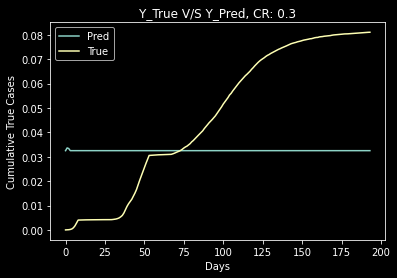

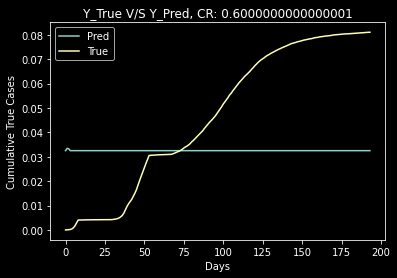

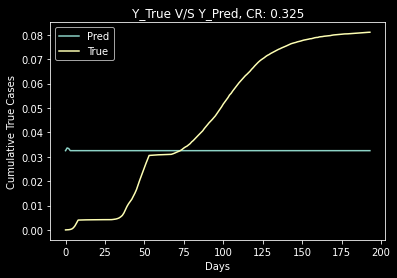

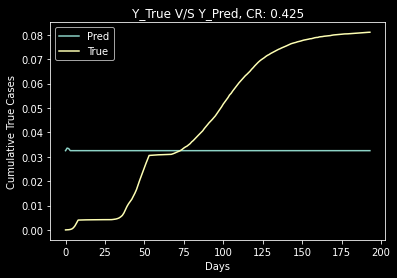

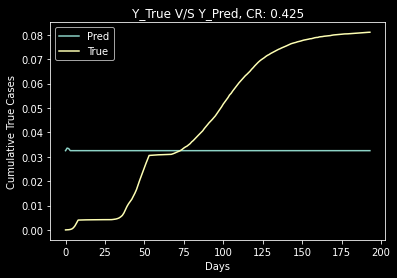

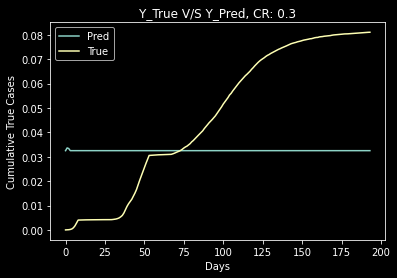

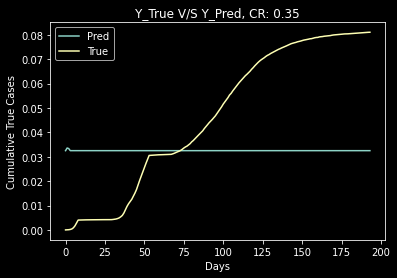

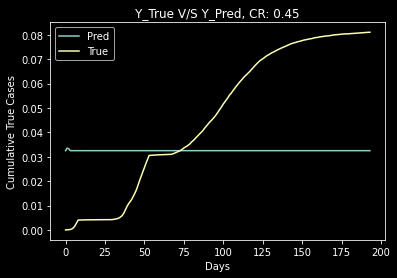

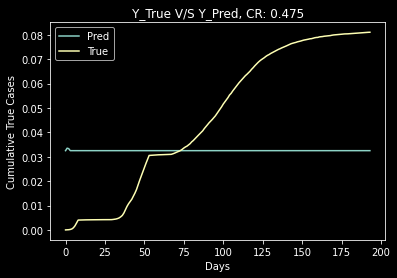

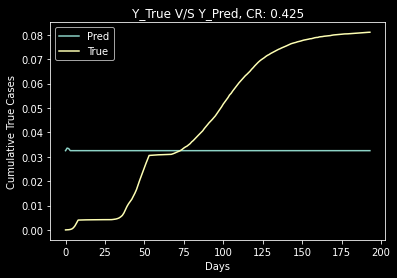

In [90]:
visualize(y_test=y_true, y_pred=y_pred, test_seq=test_seq, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)